In [1]:
import scipy.integrate as ss
import numpy as np
import matplotlib.pyplot as plt

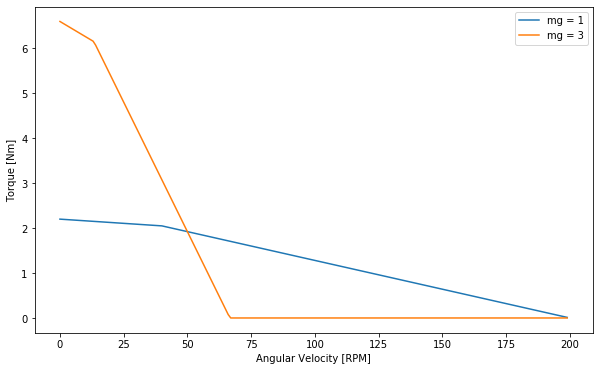

In [2]:
# Gear ratio optimizer for a vehicle power by a DC motor curve.
# It optimizes for 4 meters of acceleration then 2 meters of evalution in which the average speed is taken
# For MECH 323

#Zijian Meng 03/05/2021


#Define a power torque speed curve. This is unique to the motor and gear ratio. 
#I have estimate the curve using linear segments based on the actual torque speed curve of the motor used.
#args: W: angular velocity [rad/s]; mg: gear ratio
def TFromW(W,mg):
    W =  W* 60 /2 / np.pi
    if(W<40/mg):
        return (2.2*mg - W * (2.2-2.05)*mg / (40/mg))
    if(W>=200/mg):
        return 0 
    if(W>=40/mg):
        return (2.05*mg - ((W-40/mg)*(2.05*mg)/(160/mg)))

#Generate a plot of the rough speed torque curve to verify
w = np.arange(0,200) * 2 * np.pi / 60
T = np.zeros(200)


plt.figure(figsize=(10,6))
plt.xlabel("Angular Velocity [RPM]")
plt.ylabel("Torque [Nm]")

mg = 1   

for i in range(len(w)):
    T[i] =TFromW(w[i],mg)
plt.plot(w* 60 /2 / np.pi /mg,T,label = "mg = 1")

   
for i in range(len(w)):
    T[i] =TFromW(w[i],3)
plt.plot(w* 60 /2 / np.pi /mg,T,label = "mg = 3")
plt.legend()


1.1111111111111112
1.2539184952978057
MG = 1
0.9900990099009903
Torque
0.6244702579699903
0.4008016032064128
Optimal: [0.5546875]
1.2698412698412704
1.3222064123805322
202.0182588654362
0


Text(0, 0.5, 'Speed [m/s]')

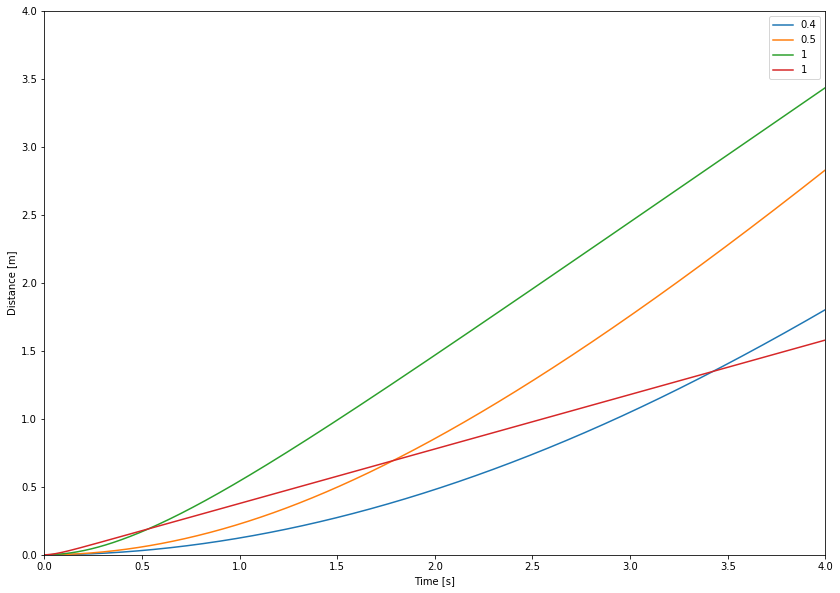

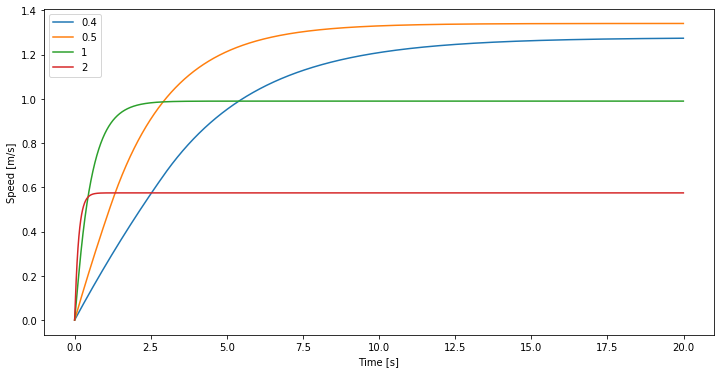

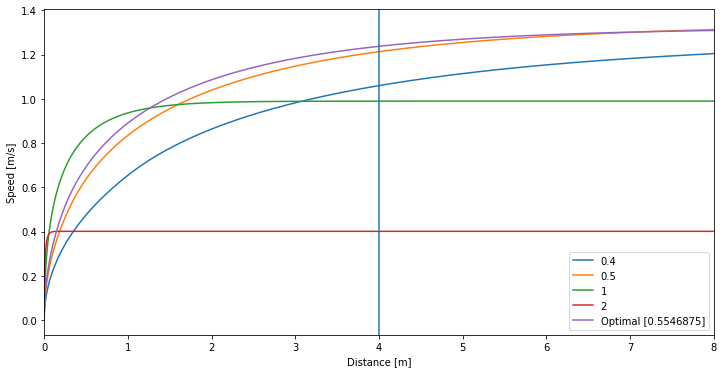

In [3]:
#Constants from the expected system setup
R = 10    # Expected friction [N]
r = 0.0625    #Wheel radius [m]
I = 9.765625E-4     #Area moment of inertia [m^4]
m = 15       #Mass of vehicle   [kg]
n = 1    #Efficiency of energy transfer. (Left as 1 for now)


# Function for the force at a given moment in time
# Args:   y: tuple(positon[m], velocity[m/s]) ;  t: time [s];   mg: gear ratio
# Returns: force in specified conditions [N]
def force(y, t, mg,s):
    pos, vel = y
    num = n*TFromW(vel/r,mg)/r - R
    den = 4*I/(r**2) +m
    dydt = [vel, num/den]
    return dydt


# Used an approiate time step
plt.figure(figsize=(14,10))
t = np.arange(0,20,0.005)
yo = [0,0]

#Experimenting with a few sample gear ratios to validate
out = ss.odeint(force,yo,t, args = (0.4,0))   #Use odeint for numerial ODE solving
plt.plot(t,out[:,0], label = "0.4")
out = ss.odeint(force,yo,t, args = (0.5,0)) 
plt.plot(t,out[:,0], label = "0.5")


out = ss.odeint(force,yo,t, args = (1,0)) 
plt.plot(t,out[:,0], label = "1")

out = ss.odeint(force,yo,t, args = (3,0)) 
plt.plot(t,out[:,0], label = "1")

plt.ylim(0,4)
plt.xlim(0,4)
plt.legend()
plt.ylabel("Distance [m]")
plt.xlabel("Time [s]")


plt.figure(figsize=(12,6))
out = ss.odeint(force,yo,t, args = (0.4,0)) 
plt.plot(t,out[:,1], label = "0.4")
out = ss.odeint(force,yo,t, args = (0.5,0)) 
plt.plot(t,out[:,1], label = "0.5")
out = ss.odeint(force,yo,t, args = (1,0)) 
plt.plot(t,out[:,1], label = "1")
out = ss.odeint(force,yo,t, args = (2,0)) 
plt.plot(t,out[:,1], label = "2")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")

#Function for finding the speed at the nearest timestep
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

plt.figure(figsize=(12,6))
out = ss.odeint(force,yo,t, args = (0.4,0)) 
plt.plot(out[:,0],out[:,1], label = "0.4")
print( 2/(t[find_nearest(out[:,0],6)] - t[find_nearest(out[:,0],4)])   )

out = ss.odeint(force,yo,t, args = (0.5,0)) 
plt.plot(out[:,0],out[:,1], label = "0.5")
print( 2/(t[find_nearest(out[:,0],6)] - t[find_nearest(out[:,0],4)])   )


out = ss.odeint(force,yo,t, args = (1,0)) 
plt.plot(out[:,0],out[:,1], label = "1")
print("MG = 1")
print( 2/(t[find_nearest(out[:,0],6)] - t[find_nearest(out[:,0],4)])   )
print("Torque")
print(TFromW(0.99/0.0625,1))



out = ss.odeint(force,yo,t, args = (3,0)) 
plt.plot(out[:,0],out[:,1], label = "2")
print( 2/(t[find_nearest(out[:,0],6)] - t[find_nearest(out[:,0],4)])   )


#Optimization for speed
from scipy.optimize import minimize

#Define a cost function for the average speed between the four meter and six meter mark
def opti(mgx):
    temp = ss.odeint(force,yo,t, args = (mgx,0)) 
    return -2/(t[find_nearest(temp[:,0],6)] - t[find_nearest(temp[:,0],4)])

ans = minimize(opti,[1], method = 'Nelder-Mead')

out = ss.odeint(force,yo,t, args = (ans.x,0)) 
plt.plot(out[:,0],out[:,1], label = "Optimal {}".format(ans.x))
print("Optimal:", ans.x)
print( 2/(t[find_nearest(out[:,0],6)] - t[find_nearest(out[:,0],4)])   )
print(np.max(out[:,1]))
print(np.max(out[:,1])/r * 60/2/np.pi)
print(TFromW(np.max(out[:,1])/r * 60/2/np.pi,ans.x))
plt.xlim(0,8)
plt.legend()
plt.axvline(4)
plt.xlabel("Distance [m]")
plt.ylabel("Speed [m/s]")
